
### **Gaussian Beam Profile Extraction**

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021

In [49]:
# import relevant modules
import beam_funcs as bf
import fit_funcs as ff
import matplotlib.pyplot as mp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import sys
mp.style.use('signature.mplstyle')

# directory and folder for images
folder = ['75mm focus']
root = r"C:\Users\sk88\Desktop\995 collimation"
dir = os.path.join(root, folder[0])
# image laser wavelength(mm)
ff.wavelength = 995e-6
# chip and pixel size (mm) if known (Hamamatsu 9.6 x 7.68 mm, DK 1.411cm)
chip_size = [9.6, 7.68]
chip_size_x =  9.6
chip_size_y = 7.68
# material refractive index
n = 1.0003
# see curve fit docs for methods
method = 'dogbox'
# tolerance in waist and waist position for fitting
multiplier = 0.5 / 100
# to save data / plots and to show plots
excel_save = False
plot_show = True
plot_save = False
# quick waist calculation - no waist fit / find
quick_show = False
# params for directory interogate
image_exts = ('.tif', '.bmp')
ext = image_exts + ('.csv',)


##### Import Data & Perfom Fit

In [50]:
# extract data from folder
folders, files = bf.dir_interogate(path=root, extensions=ext, choose_folders=folder)
image_files = [i for i in files if i.endswith(image_exts)]
z_file = [ i for i in files if i.endswith('.csv')]
# display error if file incorrect format
if not z_file:
    sys.exit('Excel file does not exist or must be of format ".csv"')
 # warn user if insufficient data to continue
if len(image_files) % 2 != 0:
    sys.exit('Number of image files must be even')
# determine length of arrays needed
array_len = int(len(image_files)/2)
distances = bf.open_excel(os.path.join(dir, z_file[0]))
if len(distances) != array_len:
    sys.exit('Number of images and z-distance mismatch')

data = []
fit_data = np.empty([array_len, 2, 3])
fit_err = np.empty([array_len, 2, 3])

for index, image_file in enumerate(image_files):
    if index < array_len:

        beam_image = os.path.join(dir, image_files[2 * index])
        beam_bkd = os.path.join(dir, image_files[2 * index + 1])
        data.append(bf.norm_image(beam_image, beam_bkd))
        fit_data[index, :, :], fit_err[index, :, :] = ff.fitgauss(data[index])

pix_size = bf.get_pix_size(beam_image, chip_size)

scale_data = np.abs(fit_data) * pix_size[0]
scale_err = np.abs(fit_err) * pix_size[0]
fit_data[:, 0, 1:] = np.abs(fit_data[:, 0, 1:]) * pix_size[0]
fit_err[:, 0, 1:] = np.abs(fit_err[:, 0, 1:]) * pix_size[0]
fit_data[:, 1, 1:] = np.abs(fit_data[:, 1, 1:]) * pix_size[1]
fit_err[:, 1, 1:] = np.abs(fit_err[:, 1, 1:]) * pix_size[1]

FWHM_err = np.array(scale_err[:, :, 2] / scale_data[:, :, 2])
# calculate FWHM & 1/e^2 (um)
FWHM = 2 * np.sqrt(2 * np.log(2)) *fit_data[:, :, 2]
FWHM_xy = [np.reshape(FWHM[:, 0], (len(FWHM),1)), np.reshape(FWHM[:, 1], (len(FWHM),1))]
FWHM_err = [np.reshape(FWHM_err[:, 0] * np.ravel(FWHM_xy[0]), (len(FWHM),1)), np.reshape(FWHM_err[:, 1] * np.ravel(FWHM_xy[1]),  (len(FWHM),1))]
e2_xy = [FWHM_xy[0] / np.sqrt(2*np.log(2)), FWHM_xy[1] / np.sqrt(2*np.log(2))]
e2_err = [FWHM_err[0] / np.sqrt(2*np.log(2)), FWHM_err[1] / np.sqrt(2*np.log(2))]
# params for fitting to hyperbolic
e2_params = [(np.amin(e2_xy[0]), distances[np.argmin(e2_xy[0])]), (np.amin(e2_xy[1]), distances[np.argmin(e2_xy[1])])]
e2x_lims = ([np.amin(e2_xy[0]) * 1 - multiplier, distances[np.argmin(e2_xy[0])] * 1 - multiplier], [np.amin(e2_xy[0]) * 1 + multiplier, distances[np.argmin(e2_xy[0])] * 1 + multiplier])
# find the fit parameters for the hyerbolic function
e2x, e2x_err = ff.fithyp(distances, np.ravel(e2_xy[0]), e2_params[0], meth=method, lims=e2x_lims)
e2y, e2y_err = ff.fithyp(distances, np.ravel(e2_xy[1]), e2_params[1], meth=method)
# calculate rayleigh range and divergence angle
zr = [(np.pi * n * e2x[0] ** 2)/ff.wavelength, (np.pi * n * e2x[0] ** 2)/ff.wavelength]
theta = [(ff.wavelength / (np.pi * n * e2y[0])) * (180/np.pi), (ff.wavelength / (np.pi * n * e2y[0])) * (180/np.pi)]
# print out waist values and rayleigh range
print('x 1/e^2 waist = ' + '%.2f ' % e2x[0] + 'p/m ' + '%.2f mm' % e2x_err[0] + ' located at ' + '%.2f' % (e2x[1])+ ' p/m ' + '%.2f mm' % (e2x_err[1]))
print('y 1/e^2 waist = ' + '%.2f ' % e2y[0] + 'p/m ' + '%.2f mm' % e2y_err[0] + ' located at ' + '%.2f' % (e2y[1])+ ' p/m ' + '%.2f mm' % (e2y_err[1]))
print('x rayleigh range = ' + '%.2f mm ' % zr[0] + 'with divergence angle = ' + '%.2f deg' % theta[0])
print('y rayleigh range = ' + '%.2f mm ' % zr[1] + 'with divergence angle = ' + '%.2f deg' % theta[1])

x 1/e^2 waist = 0.17 p/m 0.10 mm located at 25.00 p/m 144.00 mm
y 1/e^2 waist = 0.23 p/m 0.36 mm located at 213.77 p/m 91.97 mm
x rayleigh range = 88.22 mm with divergence angle = 0.08 deg
y rayleigh range = 88.22 mm with divergence angle = 0.08 deg



##### Plotting of Hyperbolic & Images

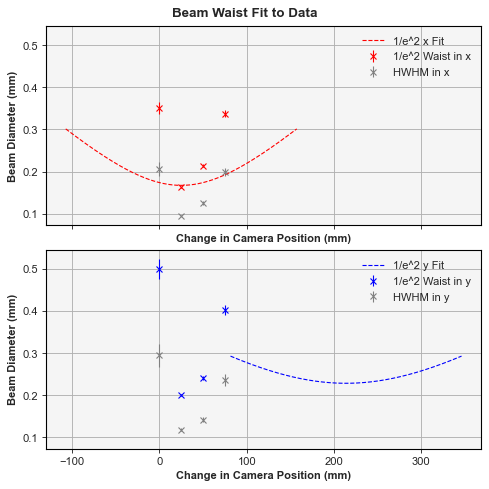

In [51]:
# set up x values for plotting
zx_plot = np.linspace(start=-1.5 * zr[0], stop = 1.5*zr[0], num=1000, endpoint=True) + e2x[1]
zy_plot = np.linspace(start=-1.5 * zr[1], stop = 1.5*zr[1], num=1000, endpoint=True) + e2y[1]
# set up figure space for error bars and hyperbolic fit
fig_1, ax_1 = mp.subplots(nrows=2, ncols=1, sharex='all', sharey='all', constrained_layout=True)
# real beam data plots 1/e^2 (x & y)
ax_1[0].errorbar(distances, e2_xy[0].flatten(), yerr = e2_err[0].flatten(), label='1/e^2 Waist in x', markersize=5, color='red', fmt='x')
ax_1[1].errorbar(distances, e2_xy[1].flatten(), yerr = e2_err[1].flatten(), label='1/e^2 Waist in y', markersize=5, color='blue', fmt='x')
# real beam data plots FWHM (x & y)
ax_1[0].errorbar(distances, 0.5 * FWHM_xy[0].flatten(), yerr = FWHM_err[0].flatten(), label='HWHM in x', markersize=5, color='grey', fmt='x')
ax_1[1].errorbar(distances, 0.5 * FWHM_xy[1].flatten(), yerr = FWHM_err[1].flatten(), label='HWHM in y', markersize=5, color='grey', fmt='x')
# hyperbolic fit (x & y)
ax_1[0].plot(zx_plot, ff.hyperbolic(zx_plot, e2x[0], e2x[1]), linestyle='--', label='1/e^2 x Fit', color='red')
ax_1[1].plot(zy_plot, ff.hyperbolic(zy_plot, e2y[0], e2y[1]), linestyle='--', label='1/e^2 y Fit', color='blue')

# format plots
fig_1.suptitle('Beam Waist Fit to Data')
for ax in ax_1:
    ax.set(xlabel='Change in Camera Position (mm)', ylabel='Beam Diameter (mm)')
    ax.legend(loc='best')

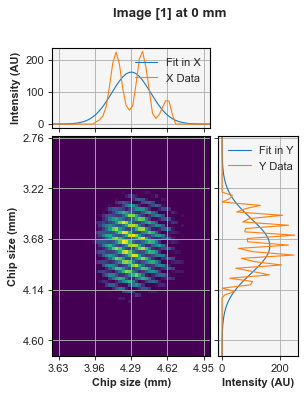

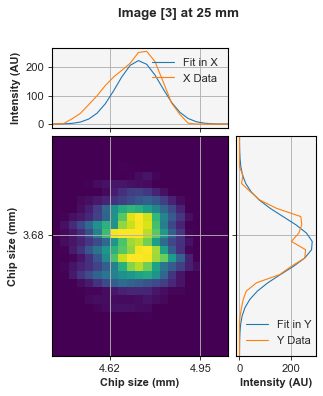

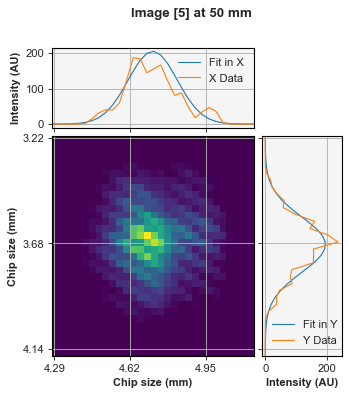

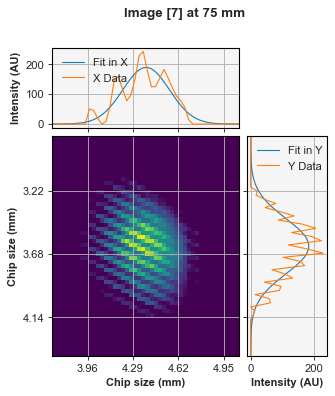

In [52]:
x = np.linspace(0, chip_size[0], 320)
y = np.linspace(0, chip_size[1], 256)

img_idx = (np.arange(1, len(image_files), 2)).reshape(len(FWHM),1)

for index, data_array in enumerate(data):

    # define figure and axes
    fig_2, ax_2 = mp.subplots(figsize=(5, 5))
    # plot image
    ax_2.imshow(np.transpose(data_array), extent=[0, chip_size[0], chip_size[1], 0])

    # add top and left subplots
    divider = make_axes_locatable(ax_2)
    ax_fitx = divider.append_axes("top", 1, pad=0.1, sharex=ax_2)
    ax_fity = divider.append_axes("right", 1, pad=0.1, sharey=ax_2)
    # remove corresponding axes labels
    ax_fitx.xaxis.set_tick_params(labelbottom=False)
    ax_fity.yaxis.set_tick_params(labelleft=False)
    # Gaussian fit in x
    ax_fitx.plot(x, ff.gaussian(x, *fit_data[index, 0, :]), label='Fit in X')
    ax_fitx.plot(x, data_array[:, round(fit_data[index, 1, 1]/pix_size[0])], label='X Data')
    # Gaussian fit in y
    ax_fity.plot(ff.gaussian(y, *fit_data[index, 1, :]), y, label='Fit in Y')
    ax_fity.plot(data_array[round(fit_data[index, 0, 1]/pix_size[1]), :], y, label='Y Data')
    # axis label formatting
    ticks = np.linspace(start=0, stop=np.max(data[index]), num=4)
    ax_fity.set_yticks(ticks)
    ax_2.set_xticks(np.arange(0, chip_size[0], round(e2x[0] * 2, ndigits=2)))
    ax_2.set_yticks(np.arange(0, chip_size[1], round(e2y[0] * 2, ndigits=2)))

    llim = round(fit_data[index, 0, 1], ndigits=2) - 4 * round(fit_data[index, 0, 2], ndigits=2)
    rlim = round(fit_data[index, 0, 1], ndigits=2) + 4 * round(fit_data[index, 0, 2], ndigits=2)
    tlim = round(fit_data[index, 1, 1], ndigits=2) - 4 * round(fit_data[index, 1, 2], ndigits=2)
    blim = round(fit_data[index, 1, 1], ndigits=2) + 4 * round(fit_data[index, 1, 2], ndigits=2)
    ax_2.set_xlim(left=llim, right=rlim)
    ax_2.set_ylim(top=tlim, bottom=blim)

    # format labels
    ax_2.set(xlabel='Chip size (mm)', ylabel='Chip size (mm)')
    ax_fitx.set(ylabel='Intensity (AU)')
    ax_fity.set(xlabel='Intensity (AU)')
    
    ax_fitx.legend(loc='best')
    ax_fity.legend(loc='best')

    if quick_show == 0:
        fig_2.suptitle('Image ' + str(img_idx[index]) + ' at ' + str((distances[index])) + ' mm')
    else:
        fig_2.suptitle('Image ' + str(img_idx[index]) + ' waist ' + str((e2_xy[0][index])) + ' mm')


    if plot_save == True:
        fig_1.savefig(fname=dir + '_' + 'beam_waist_fit', dpi=80, format='png')
        fig_2.savefig(fname=dir + '_' + str(img_idx[index]) + 'fit.pdf', dpi='figure', format='pdf')

if plot_show == True:
    mp.show()

if plot_show == True:
    mp.show()